In [15]:
import h5py
import numpy as np
from scipy import signal
from scipy.integrate import trapezoid
import matplotlib.pyplot as plt
from scipy.constants import G,c,pi,au
'''
actual noise
'''
file_path=r"C:\Users\86130\Desktop\LDC2_sangria_training_v2.h5"
def extract_obs_data(file_path):
    obs_data={}
    with h5py.File(file_path,'r') as f:
        obs_tdi=f['obs/tdi'][:]
        if obs_tdi.ndim == 2 and obs_tdi.shape[1] == 1:
            obs_tdi=obs_tdi.flatten()
        obs_data['obs_time']=obs_tdi['t']
        obs_data['obs_X']=obs_tdi['X']
        obs_data['obs_Y']=obs_tdi['Y']
        obs_data['obs_Z']=obs_tdi['Z']
        obs_data['obs_A']=(obs_tdi['Z']-obs_tdi['X'])/np.sqrt(2)
        obs_data['obs_E']=(obs_tdi['X']-2*obs_tdi['Y']+obs_tdi['Z'])/np.sqrt(6)
        obs_data['obs_dt']=obs_tdi['t'][1]-obs_tdi['t'][0]
        N=len(obs_data['obs_time'])
        obs_data['obs_frequency']=np.fft.fftfreq(N,obs_data['obs_dt'])
        obs_data['obs_df']=obs_data['obs_frequency'][1]-obs_data['obs_frequency'][0]
        obs_data['obs_X_f']=np.fft.fft(obs_data['obs_X'])
        obs_data['obs_Y_f']=np.fft.fft(obs_data['obs_Y'])
        obs_data['obs_Z_f']=np.fft.fft(obs_data['obs_Z'])
        obs_data['obs_A_f']=np.fft.fft(obs_data['obs_A'])
        obs_data['obs_E_f']=np.fft.fft(obs_data['obs_E'])
    return obs_data

def extract_all_sky_signals(file_path):
    sky_signals={}
    sources=['dgb','igb','mbhb','vgb']
    with h5py.File(file_path,'r') as f:
        for source in sources:
            tdi_path=f'sky/{source}/tdi'
            if tdi_path in f:
                tdi_data=f[tdi_path][:]
                if tdi_data.ndim==2 and tdi_data.shape[1]==1:
                    tdi_data=tdi_data.flatten()
                sky_signals[source]=tdi_data['X']
    return sky_signals

def calculate_data_noise(obs_data,sky_signals):
    total_sky_signal_X=np.zeros_like(obs_data['obs_X'])
    for source_name,signal_data in sky_signals.items():
        total_sky_signal_X+=signal_data
    instrument_noise_t=obs_data['obs_X']-total_sky_signal_X
    return instrument_noise_t

def calculate_galactic_confusion_noise(file_path):
    with h5py.File(file_path,'r') as f:
        dgb_tdi=f['sky/dgb/tdi'][:]
        dgb_tdi_X=dgb_tdi['X'].flatten()
        igb_tdi=f['sky/igb/tdi'][:]
        igb_tdi_X=igb_tdi['X'].flatten()
        galactic_confusion=dgb_tdi_X+igb_tdi_X
    return galactic_confusion

def calculate_noise_psd(obs_data,noise):
    fs=1/obs_data['obs_dt']
    nperseg=8192
    noverlap=nperseg//2
    freqs,S_n=signal.welch(
        noise,
        fs=fs,
        window='hann',
        nperseg=nperseg,
        noverlap=noverlap,
        detrend='constant',
        scaling='density',
        average='median'
    )
    return freqs,S_n

In [16]:
#Lisa Noise 
class LisaNoise:
    def __init__(self,obs_data):
        self.t=obs_data['obs_time']
        self.N=len(self.t)
        self.dt=obs_data['obs_dt']
        self.T_obs_years=1
        self.L_arm=2.5e9
        self.f_star=c/(2*np.pi*self.L_arm)
        self.freqs=np.fft.fftfreq(self.N,self.dt)

        self.A_gal=1.14e-44
        self.alpha_gal=1.8
        self.f2_gal=0.31e-3
        self.a1=-0.25
        self.b1=-2.7
        self.ak=-0.27
        self.bk=-2.47
        self.f1_gal=10**(self.a1*np.log10(self.T_obs_years)+self.b1)
        self.fk_gal=10**(self.ak*np.log10(self.T_obs_years)+self.bk)

    def calculate_OMS_PSD(self,f):
        S_OMS_nu=(6.35e-12)**2*(1+(2e-3/f)**4)*(2*np.pi*f/c)**2
        return S_OMS_nu
    
    def calculate_ACC_PSD(self,f):
        term1=(2.4e-15)**2
        term2=(1+(0.4e-3/f)**2)
        term3=(1+(f/8e-3)**4)
        S_acc_a=term1*term2*term3
        S_acc_d=S_acc_a*(2*np.pi*f)**(-4)
        S_acc_nu=S_acc_d*(2*np.pi*f/c)**2
        return S_acc_nu
    
    def calculate_TDI_noise_PSD(self,f):
        
        omega=2*np.pi*f
        L=self.L_arm
        S_OMS=self.calculate_OMS_PSD(f=f)
        S_acc=self.calculate_ACC_PSD(f=f)
        
        sin_term=np.sin(omega*L/c)
        cos_term=np.cos(2*omega*L/c)
        S_n=16*(sin_term)**2*(S_OMS+(3+cos_term)*S_acc)
        return S_n
    
    def calculate_galactic_confusion_noise(self,f):
        main_term=self.A_gal*f**(-7/3)
        decay_term=np.exp(-(f/self.f1_gal)**self.alpha_gal)
        cutoff_term=0.5*(1+np.tanh(-(f-self.fk_gal)/self.f2_gal))
        S_gal=main_term*decay_term*cutoff_term
        return S_gal
    
    def calculate_noise_strain(self,f):
        S_OMS=self.calculate_OMS_PSD(f=f)
        S_acc=self.calculate_ACC_PSD(f=f)
        phiL=2*np.pi*f*self.L_arm/c
        AvFXP2_approx=16*(3/20)*(1/(1+0.6*(2*np.pi*f*self.L_arm/c)**2))
        S_hX=(S_OMS+S_acc*(3+np.cos(2*phiL)))/(phiL**2*AvFXP2_approx/4**2)
        return S_hX

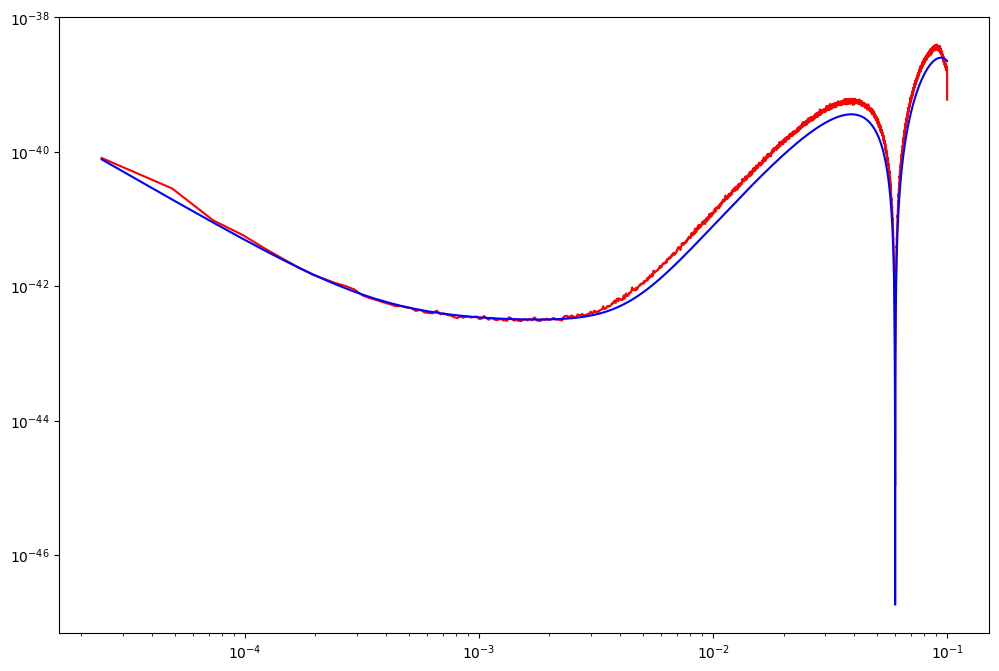

In [17]:
''' 用数值S_n匹配数据文档中的仪器噪声'''
obs_data=extract_obs_data(file_path)
sky_signals=extract_all_sky_signals(file_path)
instrument_noise_t=calculate_data_noise(obs_data,sky_signals)
freqs,S_n_data=calculate_noise_psd(obs_data,instrument_noise_t)
noise_model=LisaNoise(obs_data)
# use postive frequency
mask=(freqs>0)
pos_freqs=freqs[mask]
pos_S_n_data=S_n_data[mask]
S_n=noise_model.calculate_TDI_noise_PSD(f=pos_freqs)
plt.figure(figsize=(12,8))
plt.loglog(pos_freqs,pos_S_n_data,'r')
plt.loglog(pos_freqs,S_n,'b')
plt.show()

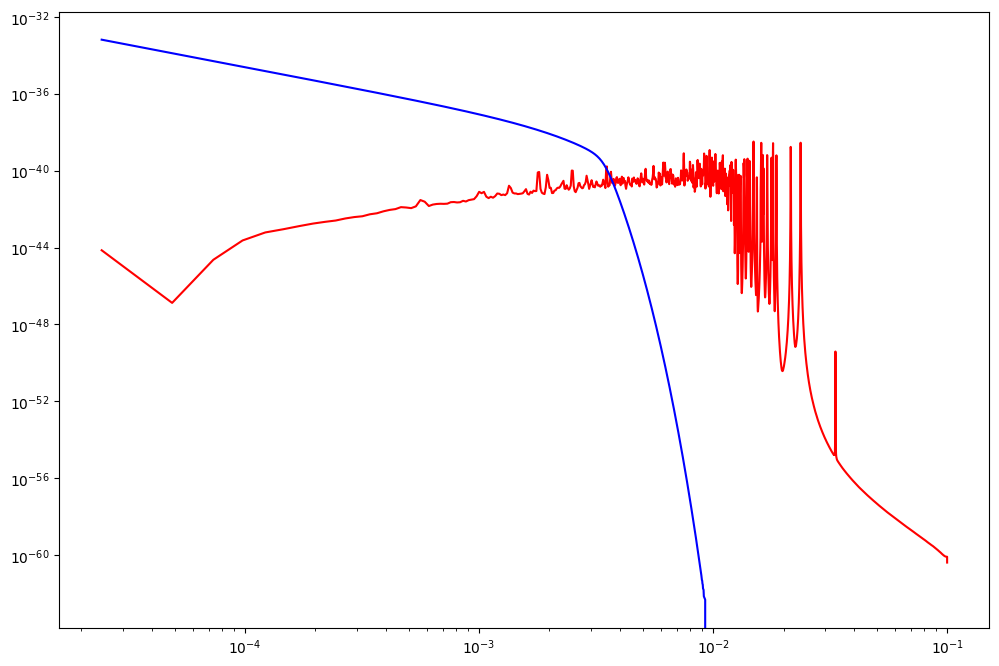

In [14]:
#考虑银河系内混淆噪声
galatic_noise=calculate_galactic_confusion_noise(file_path)
freqs,gala_S_n_data=calculate_noise_psd(obs_data,noise=galatic_noise)

gala_S_n=noise_model.calculate_galactic_confusion_noise(f=pos_freqs)
gala_S_n_data_pos=gala_S_n_data[mask]
plt.figure(figsize=(12,8))
plt.loglog(pos_freqs,gala_S_n_data_pos,'r')
plt.loglog(pos_freqs,gala_S_n,'b')
plt.show()

